In [1]:
import keras
import xmltodict
import os
import typing
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import numpy as np
import cv2
import json
from pathlib import Path

Using TensorFlow backend.


In [2]:
#import all libraries
from PIL import Image, ImageOps,ImageFilter
#import cv2
import time
import argparse
from scipy import ndimage
from scipy import misc
%matplotlib inline
import readline
readline.parse_and_bind("tab: complete")
from scipy import ndimage
from multiprocessing.pool import ThreadPool

from urllib.request import Request, urlopen, HTTPError
import ssl

In [3]:
#Image processing for resizing images
def fix_aspect_ratio(img,expected_dimension):
    original_max_dim = max(float(img.size[0]),float(img.size[1]))
    original_min_dim = min(float(img.size[0]),float(img.size[1]))
    wpercent = (expected_dimension/float(original_max_dim))
    hsize = int((original_min_dim*float(wpercent)))
    new_im = img.resize((expected_dimension,hsize), Image.ANTIALIAS)
    return new_im

In [4]:
# Make square images
def make_square(img, min_size=120, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [5]:
# Sharpen the edges
from pylab import *
def sharpen_filter(img):
    sharp_im = img.filter(ImageFilter.SHARPEN)
    return sharp_im

In [6]:
# Load dataset of logos in a dataframe
def get_logos_df(glob_path,dir_litw_resized,folder,size_threshold):
    df_logos = pd.DataFrame(columns=['true_logo','logo_img_name','original_image_name','logo_img_path','company_brand','X_size','Y_size'])
     # in each folder, find image file and resize-scale them without distortion
    index_image= 1;
    expected_dimension=120
    image_numbers = 200
    
    #image_array = np.ndarray((image_numbers,120,120,3),dtype=np.uint8)
    glob_path_complete = os.path.join(glob_path,folder)
    
    files = [f_img_name for f_img_name in glob.glob(glob_path_complete + "**/*.jpg", recursive=True)]
    print(len(files))
    
    mod_folder_name = 'Mod-' + str(folder)
    mod_full_dir = os.path.join(dir_litw_resized,mod_folder_name) 
    
    for filename in files:
         with open(filename) as imagefile:
            head, tail = os.path.split(filename)            
            orig_img = os.path.join(glob_path_complete,tail)            
            img_mod_name = folder +'-AB-'+ str(index_image) +'.png'
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name)
            
            
            company_brand_name = folder
            image_original = Image.open(orig_img)
            get_file_data_shape_x, get_file_data_shape_y = image_original.size
            max_size_dimension = max(float(get_file_data_shape_x),float(get_file_data_shape_y))
            if max_size_dimension < size_threshold:
                continue
            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            
            row = pd.Series({'true_logo' :1,
                            'logo_img_name' :img_mod_name,
                             'original_image_name' :orig_img,
                             'logo_img_path' :path_to_image,
                             'company_brand' :folder,
                             'X_size' :get_file_data_shape_x,
                             'Y_size' :get_file_data_shape_y})
            df_logos = df_logos.append(row,ignore_index=True)            
            
            file_name=os.path.join(mod_full_dir,img_mod_name)
            misc.imsave(file_name, im_med)
            index_image =index_image+1                 
    return df_logos     
           
        

In [7]:
# Prepare the logos dataset datastructure
# Set threshold for the size of the logo images to avoid heavy distortion due to resize
def get_all_images():
    dir_litw=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/data/")
    dir_litw_resized=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/resized_data")
    df_list=[]

    for folder in sorted(os.listdir(dir_litw), key=str.casefold):
        glob_path_complete = os.path.join(dir_litw,folder)
    
        files = [f_img_name for f_img_name in glob.glob(glob_path_complete + "**/*.jpg", recursive=True)]
    #if len(files) < 99:
        #continue  
        size_threshold=62
        df_list.append(get_logos_df(dir_litw,dir_litw_resized,folder,size_threshold))
    
        tp_df = pd.concat(df_list, ignore_index=True)      
        
    return tp_df

In [8]:
# Get the count of images in each brand
def Get_brand_img_count(threshold_count):
    # Plotn the graphs for demo
    tp_df=get_all_images()
    print(str(tp_df.shape))
    print("X median",str(tp_df['X_size'].median()))
    print("X mean",str(tp_df['X_size'].mean()))

    print("Y median",str(tp_df['Y_size'].median()))
    print("Y mean",str(tp_df['Y_size'].mean()))
    tp_group_by=tp_df.groupby('company_brand').size().plot(kind='bar',color='green')
    plt.show()
    # Get image counts per brand
    tp_group_by_stage1=tp_df.groupby('company_brand').size()
    fp_series = pd.Series(tp_df['company_brand']).value_counts()
    plt.figure(figsize=(15, 5))
    fp_series[fp_series > threshold_count].plot.bar(color='limegreen')
    fp_series[fp_series > threshold_count].head()
    plt.rcParams.update({'font.size': 18})
    Count_brand_logos=(fp_series.values)
    print((Count_brand_logos))
    
    return Count_brand_logos, tp_df

227


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


222
44
2
11
37
99
309
167
100
14
214
9
(288, 7)
X median 90.5
X mean 122.95833333333333
Y median 66.0
Y mean 85.75347222222223


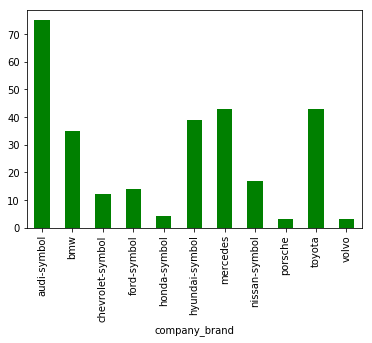

[75 43 43 39 35 17 14 12  4  3  3]


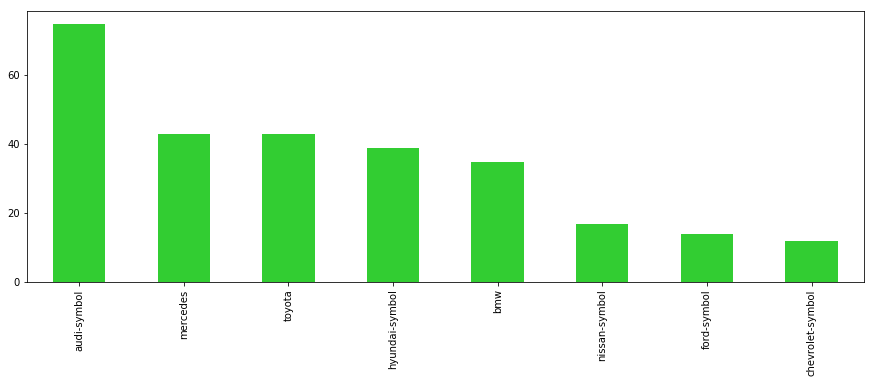

In [9]:
# Call counting and plotting functions for gathering dataset information
[Count_brand_logos,tp_df] = Get_brand_img_count(10)


In [10]:
# Filter images from the dataset and select brands with larger number of images
def create_matrix(df, *company_names):
    
    df_filtered=df[df['company_brand'].isin(company_names)]
       
    return df_filtered

In [11]:
# get all brand images that are resizes, processed. these brands have sufficient data for training
df_filtered=create_matrix(tp_df,'audi-symbol','toyota','mercedes')
df_filtered.head()


,true_logo,logo_img_name,original_image_name,logo_img_path,company_brand,X_size,Y_size
0,1,audi-symbol-AB-1.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,85,45
1,1,audi-symbol-AB-2.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,146,72
2,1,audi-symbol-AB-3.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,180,67
3,1,audi-symbol-AB-4.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,83,117
4,1,audi-symbol-AB-5.png,c:\Users\Sanyogita\Documents\Insight\projects\...,c:\Users\Sanyogita\Documents\Insight\projects\...,audi-symbol,70,76


In [12]:
# select few samples from the company brands to evaluate the feasibility of the co-occurrence matrix
# Output: Input images X and their labels y
from skimage.feature import greycomatrix, greycoprops
from skimage import data,io
import matplotlib.image as mpimg

def Get_initial_data(df_filtered,Count_brand_logos):
    xs = []
    ys = []
    
    defect_image_num = len(df_filtered) # number of distinct brands*num_of images_each_brand base don the threshold
    print(defect_image_num)
    defect_imgs = np.ndarray((defect_image_num, 120, 120), dtype=np.uint8)
    y = np.array(df_filtered['true_logo'],dtype=int)
    index = 0

    for index_df, record in df_filtered.iterrows():
        x = io.imread(record['logo_img_path'])
        red = x[:,:,2]
        green = x[:,:,1]
        blue = x[:,:,0]
        image_2D = x[:,:,3]
        #glcm = greycomatrix(nir,  [5], [0, np.pi/4, np.pi/2], levels=256, normed=True, symmetric=True)
        glcm = greycomatrix(image_2D,[5], [0], levels=256, symmetric=True, normed=True)
        xs.append(greycoprops(glcm, 'correlation')[0, 0])
        ys.append(greycoprops(glcm, 'dissimilarity')[0, 0])
        index += 1
        X = defect_imgs        

    fig = plt.figure(figsize=(8, 8)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xs[:Count_brand_logos[0]], ys[:Count_brand_logos[0]], 'go',
        label='audi')
    ax.plot(xs[:Count_brand_logos[1]], ys[:Count_brand_logos[1]], 'bo',
        label='toyota')
    ax.plot(xs[:Count_brand_logos[2]], ys[:Count_brand_logos[2]], 'rs',
        label='mercedes')
    ax.set_xlabel('GLCM correlation',fontsize=28)
    ax.set_ylabel('GLCM dissimilarity',fontsize=28)
    ax.legend()
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='20') 
    plt.rcParams.update({'font.size': 28})
    return X,y    

161


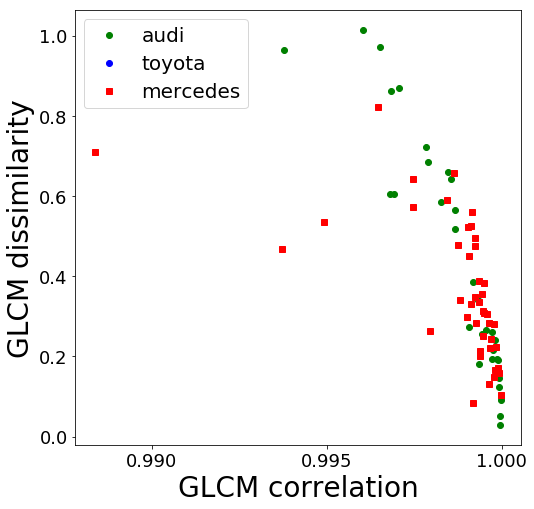

In [13]:
#Get all the images and labels
#Plot the similarity matrix
X,y = Get_initial_data(df_filtered,Count_brand_logos)